In [1]:
# Magic line to avoid explicitely write plt.show()
%matplotlib inline

In [2]:
#do not show warnings
import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis (EDA)
This notebook will detail an exploratory data analysis of the sales dataset which will feed the forecasting model:
- As well, this will provide a quick way to check the generated/simulated data

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
sales_clusters_df=pd.read_csv('../data/raw/sales_cluster_table.csv')

In [5]:
sales_clusters_df.Cluster.value_counts()

3    148
4     78
0     32
1     17
2      4
Name: Cluster, dtype: int64

In [6]:
sales_clusters_df.head()

,product_code,noisy_date,noisy_quantity,Cluster
0,CLA0,2017-12-28,5038.619159,0
1,CLA0,2018-03-11,4658.195181,0
2,CLA0,2018-05-18,4676.433462,0
3,CLA0,2018-07-25,5067.550234,0
4,CLA0,2018-10-04,4602.628398,0


In [7]:
sales_clusters_df['noisy_date']=pd.to_datetime(sales_clusters_df['noisy_date'])

In [8]:
sales_clusters_df[sales_clusters_df.product_code=='CLA0'][['noisy_date','noisy_quantity']]

,noisy_date,noisy_quantity
0,2017-12-28,5038.619159
1,2018-03-11,4658.195181
2,2018-05-18,4676.433462
3,2018-07-25,5067.550234
4,2018-10-04,4602.628398
5,2018-12-21,4873.462946
6,2019-02-21,5336.037630
7,2019-04-21,5112.239650
8,2019-07-07,5104.938014


In [9]:
sales_clusters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 4 columns):
product_code      279 non-null object
noisy_date        279 non-null datetime64[ns]
noisy_quantity    279 non-null float64
Cluster           279 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 8.8+ KB


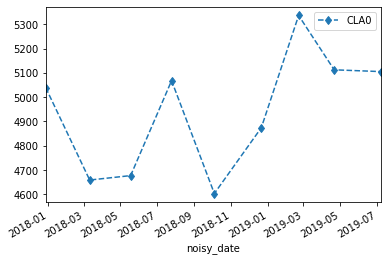

In [14]:
sales_clusters_df[sales_clusters_df.product_code=='CLA0'][['noisy_date','noisy_quantity']]\
.plot.line(x='noisy_date',y='noisy_quantity',linestyle='--',marker='d')
plt.legend(['CLA0'])

# Just a small prophet model to try the library

- I then realise we need to build a model to predict the next sale date and then the next sale quantity

In [15]:
from fbprophet import Prophet

## First model to predict next sale date

In [85]:
def generate_next_sale_column(df):
    df['next_sale_date']=df['noisy_date'].shift(-1)
    df.drop([0,len(df)-1],inplace=True)
    
    # y will be the number of days until the next sale
    df['y']=(df['next_sale_date']-df['noisy_date']).dt.days.astype(int)
    
    return df

In [86]:
prophet_date_df=sales_clusters_df[sales_clusters_df.product_code=='CLA0'][['noisy_date']].copy()

In [135]:
idx_split=int(np.floor(0.8*len(prophet_date_df)))

In [88]:
prophet_date_df=generate_next_sale_column(prophet_date_df)

In [89]:
prophet_date_df

,noisy_date,next_sale_date,y
1,2018-03-11,2018-05-18,68
2,2018-05-18,2018-07-25,68
3,2018-07-25,2018-10-04,71
4,2018-10-04,2018-12-21,78
5,2018-12-21,2019-02-21,62
6,2019-02-21,2019-04-21,59
7,2019-04-21,2019-07-07,77


In [90]:
prophet_date_df.rename(index=str, columns={"noisy_date": "ds"},
                 inplace=True)

In [93]:
next_sale_date_model=Prophet()

In [137]:
prophet_date_df[:idx_split]

,ds,next_sale_date,y
1,2018-03-11,2018-05-18,68
2,2018-05-18,2018-07-25,68
3,2018-07-25,2018-10-04,71
4,2018-10-04,2018-12-21,78
5,2018-12-21,2019-02-21,62


In [94]:
next_sale_date_model.fit(prophet_date_df[:5])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


In [95]:
next_sale_date_forecast = next_sale_date_model.predict(pd.DataFrame(prophet_date_df['ds']))

In [96]:
next_sale_date_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-03-11,69.963703,63.650160,76.150321
1,2018-05-18,69.687132,63.240423,76.373723
2,2018-07-25,69.410562,62.745135,76.075304
3,2018-10-04,69.121789,62.478936,75.515296
4,2018-12-21,68.804546,62.352341,75.777007
5,2019-02-21,68.552378,61.839633,75.030167
6,2019-04-21,68.312412,61.349412,74.936861


In [102]:
prophet_date_df

,ds,next_sale_date,y
1,2018-03-11,2018-05-18,68
2,2018-05-18,2018-07-25,68
3,2018-07-25,2018-10-04,71
4,2018-10-04,2018-12-21,78
5,2018-12-21,2019-02-21,62
6,2019-02-21,2019-04-21,59
7,2019-04-21,2019-07-07,77


In [103]:
next_sale_date_forecast['actual_y']=prophet_date_df['y'].values

In [104]:
next_sale_date_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','actual_y']]

,ds,yhat,yhat_lower,yhat_upper,actual_y
0,2018-03-11,69.963703,63.650160,76.150321,68
1,2018-05-18,69.687132,63.240423,76.373723,68
2,2018-07-25,69.410562,62.745135,76.075304,71
3,2018-10-04,69.121789,62.478936,75.515296,78
4,2018-12-21,68.804546,62.352341,75.777007,62
5,2019-02-21,68.552378,61.839633,75.030167,59
6,2019-04-21,68.312412,61.349412,74.936861,77


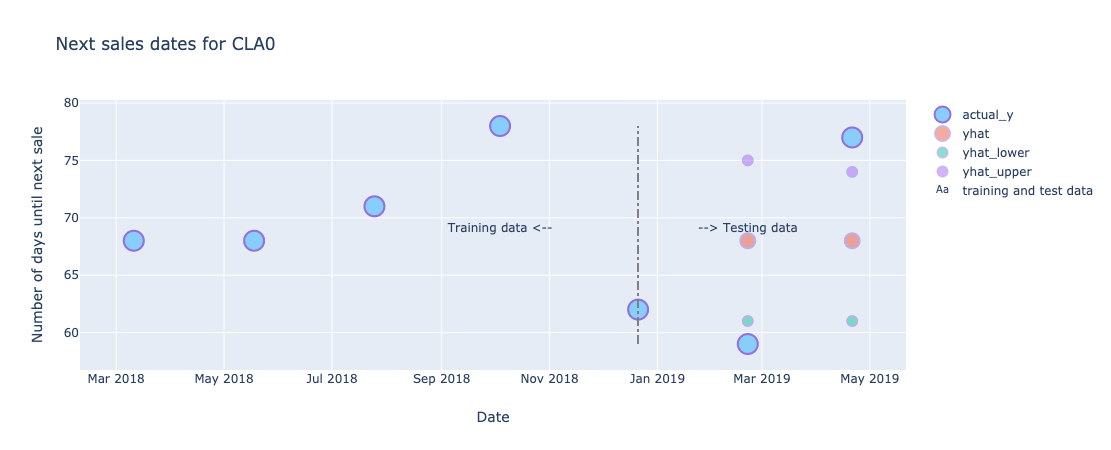

In [151]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=next_sale_date_forecast['ds'],
                         y=next_sale_date_forecast['actual_y'],
                          marker=dict(
                                    color='LightSkyBlue',
                                    size=20,
                                    line=dict(
                                        color='MediumPurple',
                                        width=2
                                    )
                                ),
                            mode='markers',
                        name='actual_y'))

fig.add_trace(go.Scatter(x=next_sale_date_forecast['ds'][idx_split:],
                         y=next_sale_date_forecast['yhat'][idx_split:].astype(int),
                         opacity=0.5,
                         marker=dict(
                                    size=15,
                                    line=dict(
                                        color='MediumPurple',
                                        width=2
                                    )
                                ),
                        mode='markers',
                        name='yhat'))


fig.add_trace(go.Scatter(x=next_sale_date_forecast['ds'][idx_split:],
                         y=next_sale_date_forecast['yhat_lower'][idx_split:].astype(int),
                         opacity=0.5,
                         marker=dict(
                                    size=10,
                                    line=dict(
                                        color='MediumPurple',
                                        width=2
                                    )
                                ),
                        mode='markers',
                        name='yhat_lower'))

fig.add_trace(go.Scatter(x=next_sale_date_forecast['ds'][idx_split:],
                         y=next_sale_date_forecast['yhat_upper'][idx_split:].astype(int),
                         opacity=0.5,
                         marker=dict(
                                    size=10,
                                    line=dict(
                                        color='MediumPurple',
                                        width=2
                                    )
                                ),
                        mode='markers',
                        name='yhat_upper'))

fig.update_layout(
    shapes=[
        # Line Vertical
        go.layout.Shape(
            type="line",
            x0=next_sale_date_forecast['ds'][idx_split-1],
            y0=np.min(next_sale_date_forecast['actual_y']),
            x1=next_sale_date_forecast['ds'][idx_split-1],
            y1=np.max(next_sale_date_forecast['actual_y']),
            line=dict(
                color="grey",
                width=2,
                dash="dashdot"
            )
        )
    ]
)

fig.add_trace(go.Scatter(
    x=[next_sale_date_forecast['ds'][idx_split-2],
      next_sale_date_forecast['ds'][idx_split]],
    y=[np.mean(next_sale_date_forecast['actual_y']),
               np.mean(next_sale_date_forecast['actual_y'])],
    text=["Training data <--",
          "--> Testing data"],
    mode="text",
    name='training and test data'
))

# Edit the layout
fig.update_layout(title='Next sales dates for CLA0',
                   xaxis_title='Date',
                   yaxis_title='Number of days until next sale')



fig.show()

In [152]:
prophet_qty_df=sales_clusters_df[sales_clusters_df.product_code=='CLA0'][['noisy_date','noisy_quantity']].copy()

In [153]:
prophet_qty_df.rename(index=str, columns={"noisy_date": "ds",
                                      "noisy_quantity": "y"},
                 inplace=True)

In [155]:
prophet_qty_df[:idx_split]

,ds,y
0,2017-12-28,5038.619159
1,2018-03-11,4658.195181
2,2018-05-18,4676.433462
3,2018-07-25,5067.550234
4,2018-10-04,4602.628398


In [156]:
qty_model=Prophet()

In [157]:
qty_model.fit(prophet_qty_df[:idx_split])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


In [161]:
next_sale_date_forecast[['ds','yhat']]

,ds,yhat
0,2018-03-11,69.963703
1,2018-05-18,69.687132
2,2018-07-25,69.410562
3,2018-10-04,69.121789
4,2018-12-21,68.804546
5,2019-02-21,68.552378
6,2019-04-21,68.312412


In [162]:
next_sale_date_forecast['ds_predicted']=next_sale_date_forecast['ds']

In [ ]:
next_sale_date_forecast['ds_predicted'][idx_split:]

In [ ]:
qty_forecast = qty_model.predict(pd.DataFrame(prophet_sales_df['ds']))

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [ ]:
fig1 = model.plot(forecast)

In [ ]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode()

fig = plot_plotly(model, forecast)  # This returns a plotly Figure
py.iplot(fig)

# Clusters analysis

In [ ]:
import plotly.graph_objects as go

In [ ]:
sales_clusters_df.head()

In [ ]:
sales_clusters_df[sales_clusters_df['Cluster']==0][['noisy_date','noisy_quantity']].info()

In [ ]:
fig = go.Figure()

for cluster in sales_clusters_df.Cluster.value_counts().index.values:
    
    fig.add_trace(go.Scatter(x=sales_clusters_df[sales_clusters_df['Cluster']==cluster]['noisy_date'].astype(str).values,
                             y=sales_clusters_df[sales_clusters_df['Cluster']==cluster]['noisy_quantity'].values,
                        mode='markers',
                        name='Cluster '+str(cluster)))

# Edit the layout
fig.update_layout(title='Labels Sales per cluster',
                   xaxis_title='Date',
                   yaxis_title='Quantities')


fig.show()

# Cluster #0 predictions

In [ ]:
cluster_prophet_df=sales_clusters_df[sales_clusters_df['Cluster']==0][['noisy_date','noisy_quantity']].copy()

In [ ]:
cluster_prophet_df.rename(index=str, columns={"noisy_date": "ds",
                                      "noisy_quantity": "y"},
                 inplace=True)

In [ ]:
cluster_prophet_df.describe()

In [ ]:
cluster_prophet_df=cluster_prophet_df.sort_values('ds')
cluster_prophet_df['cap'] = 8000
cluster_prophet_df['floor'] = 1300

In [ ]:
cluster_model=Prophet(growth='logistic',
                      changepoint_prior_scale= 0.001)

In [ ]:
cluster_model.fit(cluster_prophet_df[:25])

In [ ]:
cluster_prophet_df.info()

In [ ]:
cluster_forecast = cluster_model.predict(pd.DataFrame(cluster_prophet_df[['ds','cap','floor']]))

In [ ]:
cluster_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
cluster_prophet_df.tail()

In [ ]:
cluster_prophet_df[:25]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig1 = cluster_model.plot(cluster_forecast)
plt.scatter(cluster_prophet_df['ds'],
           cluster_prophet_df['y'],color='g')